# Hong Kong Mark Six: Hawkes-Renewal-PDE Hybrid Model Analysis

## Mathematical Review and Implementation

**Data Period:** 2024-2025  
**Framework:** Renewal Process + Hawkes Self-Exciting Process + PDE Density Diffusion

### Main Objectives

1. Implement Weibull-based Renewal process for inter-arrival time modeling
2. Simulate Hawkes self-exciting process to capture temporal clustering
3. Solve PDE for density evolution under prize influence
4. Integrate Lie group symmetry and topological analysis
5. Validate models using statistical tests (KS test, LRT)
6. Predict "hot" numbers based on intensity and density


## Section 1: Import Required Libraries and Load Data

In [1]:
# Import necessary libraries
import sys
import warnings
warnings.filterwarnings('ignore')

# Standard scientific computing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize
from scipy.integrate import odeint, solve_ivp
from scipy.special import gamma as gamma_func
from scipy.spatial.distance import pdist, squareform

# Import data fetching function
sys.path.append('/Volumes/T9/side-project/HongKongMarkSixAnalysis')
from get_lottery_data import get_lottery_data

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ All packages imported successfully")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

✓ All packages imported successfully
NumPy version: 2.3.1
Pandas version: 2.3.0


In [2]:
# Load Hong Kong Mark Six data
print("Loading Hong Kong Mark Six data (2024-2025)...")

data_raw = get_lottery_data(start_date='2024-01-01', end_date='2025-10-26')

# Convert to DataFrame
data = pd.DataFrame(data_raw)

print(f"✓ Successfully loaded {len(data)} draws")
print(f"Date range: {data['drawDate'].min()} to {data['drawDate'].max()}")
print(f"\nData shape: {data.shape}")
print(f"\nFirst 3 draws:")
data.head(3)

Loading Hong Kong Mark Six data (2024-2025)...
Date range is larger than 3 months, splitting the request from 2024-01-01 00:00:00 to 2025-10-26 00:00:00
Fetching data from 20240101 to 20240331
Fetching data from 20240401 to 20240630
Fetching data from 20240701 to 20240929
Fetching data from 20240930 to 20241229
Fetching data from 20241230 to 20250330
Fetching data from 20250331 to 20250629
Fetching data from 20250630 to 20250928
Fetching data from 20250929 to 20251026
✓ Successfully loaded 255 draws
Date range: 2024-01-03+08:00 to 2025-10-25+08:00

Data shape: (255, 12)

First 3 draws:


,id,year,no,openDate,closeDate,drawDate,status,snowballCode,snowballName_en,snowballName_ch,lotteryPool,drawResult
0,2025115N,2025,115,2025-10-23+08:00,2025-10-25T21:15:00+08:00,2025-10-25+08:00,Result,,,,"{'sell': False, 'status': 'Payout', 'totalInve...","{'drawnNo': [6, 7, 27, 36, 39, 43], 'xDrawnNo'..."
1,2025114N,2025,114,2025-10-21+08:00,2025-10-23T21:15:00+08:00,2025-10-23+08:00,Result,,,,"{'sell': False, 'status': 'Payout', 'totalInve...","{'drawnNo': [4, 19, 24, 25, 26, 46], 'xDrawnNo..."
2,2025113N,2025,113,2025-10-18+08:00,2025-10-21T21:15:00+08:00,2025-10-21+08:00,Result,,,,"{'sell': False, 'status': 'Payout', 'totalInve...","{'drawnNo': [1, 8, 9, 11, 18, 32], 'xDrawnNo':..."


In [3]:
# Explore data structure
print("Data columns:")
print(data.columns.tolist())
print("\nSample row:")
print(data.iloc[0].to_dict())

Data columns:
['id', 'year', 'no', 'openDate', 'closeDate', 'drawDate', 'status', 'snowballCode', 'snowballName_en', 'snowballName_ch', 'lotteryPool', 'drawResult']

Sample row:
{'id': '2025115N', 'year': '2025', 'no': 115, 'openDate': '2025-10-23+08:00', 'closeDate': '2025-10-25T21:15:00+08:00', 'drawDate': '2025-10-25+08:00', 'status': 'Result', 'snowballCode': '', 'snowballName_en': '', 'snowballName_ch': '', 'lotteryPool': {'sell': False, 'status': 'Payout', 'totalInvestment': '75643571', 'jackpot': '31940095', 'unitBet': 10, 'estimatedPrize': '', 'derivedFirstPrizeDiv': '40000000', 'lotteryPrizes': [{'type': 1, 'winningUnit': 0, 'dividend': '0'}, {'type': 2, 'winningUnit': 20, 'dividend': '1424430'}, {'type': 3, 'winningUnit': 1170, 'dividend': '64930'}, {'type': 4, 'winningUnit': 2565, 'dividend': '9600'}, {'type': 5, 'winningUnit': 63885, 'dividend': '640'}, {'type': 6, 'winningUnit': 92689, 'dividend': '320'}, {'type': 7, 'winningUnit': 1230178, 'dividend': '40'}]}, 'drawResult

## Section 2: Data Preprocessing and Exploration

In [4]:
# Extract main numbers (6 balls per draw) and special number
data['numbers'] = data['drawResult'].apply(lambda x: x['drawnNo'])
data['special_number'] = data['drawResult'].apply(lambda x: x['xDrawnNo'])

# Convert drawDate to datetime
data['drawDate'] = pd.to_datetime(data['drawDate'].str.replace('+08:00', '', regex=False))
data = data.sort_values('drawDate').reset_index(drop=True)
data['draw_index'] = range(len(data))
data['drawNumber'] = data['no']

# Calculate total prize pool (sum of all dividends weighted by winning units)
def calc_total_prize(lottery_pool):
    if not lottery_pool or 'lotteryPrizes' not in lottery_pool:
        return 0
    total = 0
    for prize in lottery_pool['lotteryPrizes']:
        dividend = float(prize.get('dividend', 0))
        units = int(prize.get('winningUnit', 0))
        total += dividend * units
    return total

data['total_prize'] = data['lotteryPool'].apply(calc_total_prize)

print(f"Total draws: {len(data)}")
print(f"Average total prize pool: HK$ {data['total_prize'].mean():,.0f}")
print(f"Max total prize pool: HK$ {data['total_prize'].max():,.0f}")
print(f"\nSample data:")
data[['drawDate', 'drawNumber', 'numbers', 'total_prize']].head()

Total draws: 255
Average total prize pool: HK$ 333,096,474
Max total prize pool: HK$ 3,158,420,660

Sample data:


,drawDate,drawNumber,numbers,total_prize
0,2024-01-03,1,"[2, 3, 19, 34, 37, 46]",6.480613e+08
1,2024-01-06,2,"[1, 4, 24, 31, 33, 34]",1.940283e+09
2,2024-01-09,3,"[3, 9, 16, 19, 33, 35]",2.546560e+08
3,2024-01-11,4,"[3, 6, 8, 26, 29, 38]",1.929240e+08
4,2024-01-14,5,"[3, 17, 18, 36, 38, 39]",1.846159e+08


In [5]:
# Calculate inter-arrival times for each number (1-49)
# Inter-arrival time = number of draws between consecutive occurrences

def compute_interarrival_times(data, num_range=(1, 49)):
    """
    Compute inter-arrival times for each number in the lottery.
    Returns: dictionary {number: [list of inter-arrival times]}
    """
    interarrival_dict = {n: [] for n in range(num_range[0], num_range[1] + 1)}
    last_occurrence = {n: -1 for n in range(num_range[0], num_range[1] + 1)}
    
    for idx, row in data.iterrows():
        draw_idx = row['draw_index']
        numbers = row['numbers']
        
        for num in numbers:
            if last_occurrence[num] >= 0:
                # Calculate inter-arrival time (number of draws)
                interarrival = draw_idx - last_occurrence[num]
                interarrival_dict[num].append(interarrival)
            last_occurrence[num] = draw_idx
    
    return interarrival_dict

interarrival_times = compute_interarrival_times(data)

# Summary statistics
print("Inter-arrival Time Statistics:")
print(f"Total numbers: 49")
print(f"\nSample - Number 6:")
print(f"  Occurrences: {len(interarrival_times[6]) + 1}")  # +1 for first occurrence
print(f"  Inter-arrival times: {interarrival_times[6][:10]}...")  # First 10
print(f"  Mean inter-arrival: {np.mean(interarrival_times[6]):.2f} draws")
print(f"  Std dev: {np.std(interarrival_times[6]):.2f}")

# Calculate expected mean inter-arrival time (theoretical)
# For random uniform sampling: E[inter-arrival] ≈ total_draws / occurrences
# With 6 numbers drawn from 49: p = 6/49, expected inter-arrival ≈ 49/6 ≈ 8.17
expected_interarrival = 49 / 6
print(f"\nTheoretical expected inter-arrival (random): {expected_interarrival:.2f} draws")

Inter-arrival Time Statistics:
Total numbers: 49

Sample - Number 6:
  Occurrences: 37
  Inter-arrival times: [2, 3, 20, 3, 2, 2, 6, 4, 4, 13]...
  Mean inter-arrival: 6.97 draws
  Std dev: 5.89

Theoretical expected inter-arrival (random): 8.17 draws


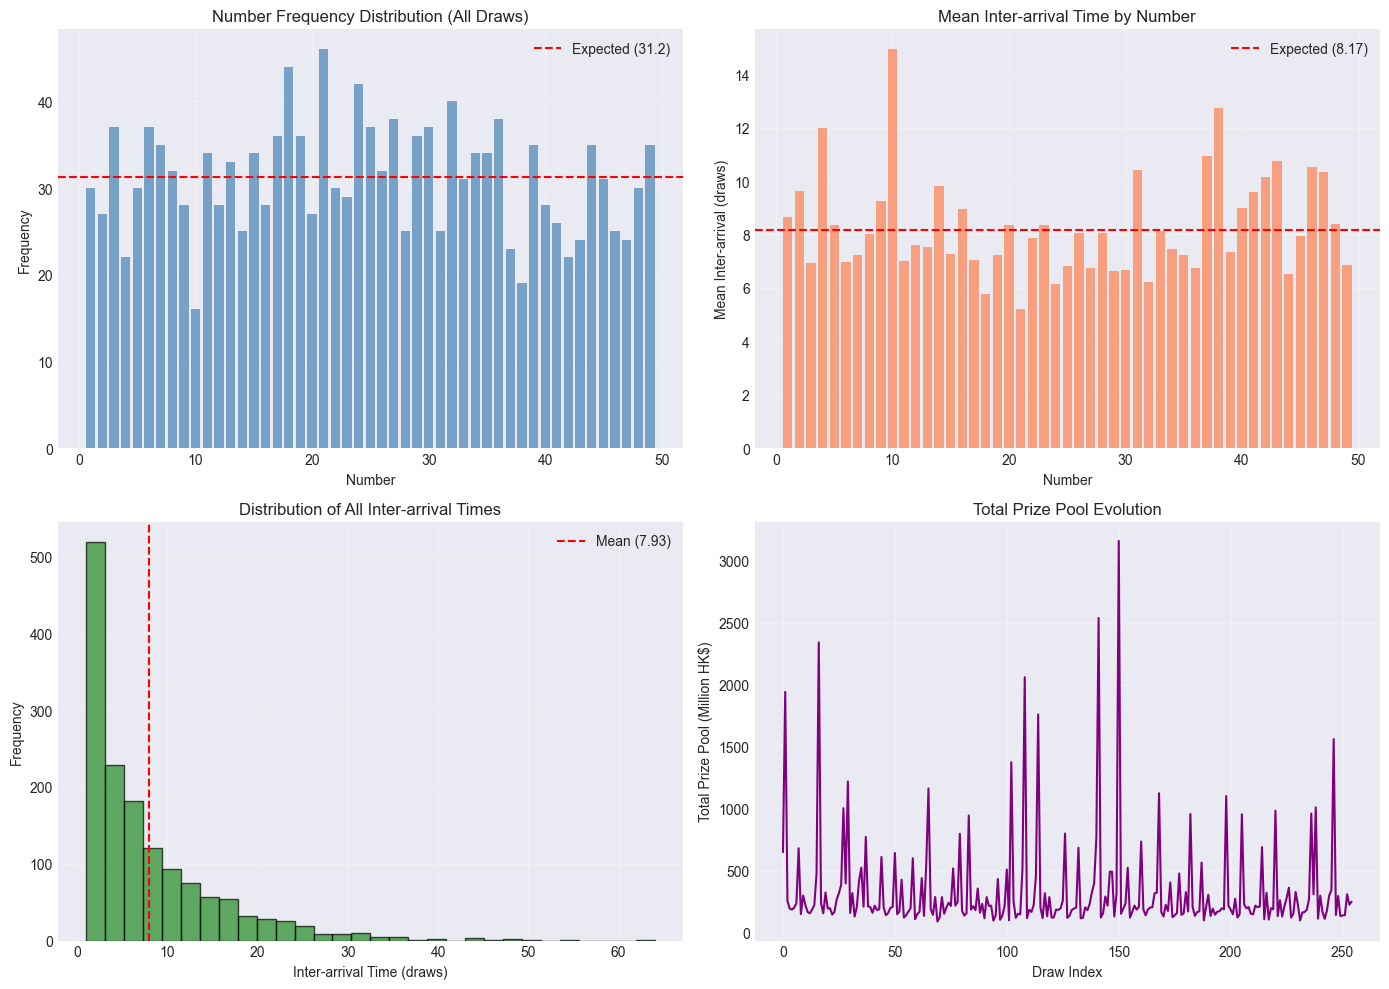


Summary Statistics:
Mean inter-arrival (empirical): 7.93 draws
Std inter-arrival: 7.74
Min/Max inter-arrival: 1 / 64 draws


In [6]:
# Visualize number frequency and inter-arrival distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Number frequency histogram
all_numbers_flat = [num for nums in data['numbers'] for num in nums]
number_counts = pd.Series(all_numbers_flat).value_counts().sort_index()

axes[0, 0].bar(number_counts.index, number_counts.values, color='steelblue', alpha=0.7)
axes[0, 0].axhline(y=len(data)*6/49, color='red', linestyle='--', label=f'Expected ({len(data)*6/49:.1f})')
axes[0, 0].set_xlabel('Number')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Number Frequency Distribution (All Draws)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Mean inter-arrival time by number
mean_interarrivals = {n: np.mean(times) if len(times) > 0 else 0 
                      for n, times in interarrival_times.items()}
axes[0, 1].bar(mean_interarrivals.keys(), mean_interarrivals.values(), 
               color='coral', alpha=0.7)
axes[0, 1].axhline(y=expected_interarrival, color='red', linestyle='--', 
                   label=f'Expected ({expected_interarrival:.2f})')
axes[0, 1].set_xlabel('Number')
axes[0, 1].set_ylabel('Mean Inter-arrival (draws)')
axes[0, 1].set_title('Mean Inter-arrival Time by Number')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Distribution of inter-arrival times (all numbers pooled)
all_interarrivals = [t for times in interarrival_times.values() for t in times]
axes[1, 0].hist(all_interarrivals, bins=30, color='forestgreen', alpha=0.7, edgecolor='black')
axes[1, 0].axvline(x=np.mean(all_interarrivals), color='red', linestyle='--', 
                   label=f'Mean ({np.mean(all_interarrivals):.2f})')
axes[1, 0].set_xlabel('Inter-arrival Time (draws)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of All Inter-arrival Times')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Total prize pool over time
axes[1, 1].plot(data['draw_index'], data['total_prize'] / 1e6, 
                color='purple', linewidth=1.5)
axes[1, 1].set_xlabel('Draw Index')
axes[1, 1].set_ylabel('Total Prize Pool (Million HK$)')
axes[1, 1].set_title('Total Prize Pool Evolution')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nSummary Statistics:")
print(f"Mean inter-arrival (empirical): {np.mean(all_interarrivals):.2f} draws")
print(f"Std inter-arrival: {np.std(all_interarrivals):.2f}")
print(f"Min/Max inter-arrival: {min(all_interarrivals)} / {max(all_interarrivals)} draws")

## Section 3: Mathematical Model Setup

Define the mathematical framework:
- **Number set**: $\mathcal{N} = \{1, 2, \ldots, 49\}$
- **Point process**: $N_n(t)$ counting occurrences of number $n$ up to time $t$
- **Intensity function**: $\lambda_n(t)$ - instantaneous occurrence rate
- **Density function**: $\rho(n,t)$ - spatial-temporal probability density

In [7]:
# Define mathematical constants and model parameters

# Number set
NUM_SET = list(range(1, 50))  # N = {1, ..., 49}
N_NUMBERS = len(NUM_SET)
N_DRAWS = len(data)

# Point process time indexing (use draw index as time)
TIME_POINTS = data['draw_index'].values

# Initialize storage for model parameters
model_params = {
    'weibull': {},    # {number: {'lambda': scale, 'kappa': shape}}
    'hawkes': {},     # {number: {'mu': baseline, 'alpha': excitation, 'beta': decay}}
    'pde': {          # Global PDE parameters
        'D': 0.01,    # Diffusion coefficient
        'gamma': 1e-9 # Prize influence scaling
    }
}

# Mathematical constants
COMB_49_6 = 13983816  # C(49,6) - total combinations
P_FIRST_PRIZE = 1 / COMB_49_6  # ≈ 7.151e-8

print("Mathematical Model Setup:")
print(f"Number set: N = {{1, ..., {N_NUMBERS}}}")
print(f"Total draws: T = {N_DRAWS}")
print(f"Time points: t ∈ [0, {N_DRAWS-1}]")
print(f"\nProbability constants:")
print(f"  Total combinations: C(49,6) = {COMB_49_6:,}")
print(f"  First prize probability: {P_FIRST_PRIZE:.2e}")
print(f"  Expected number occurrence rate: 6/49 ≈ {6/49:.4f} per draw")
print(f"\nPDE parameters:")
print(f"  Diffusion coefficient D = {model_params['pde']['D']}")
print(f"  Prize scaling γ = {model_params['pde']['gamma']:.2e}")

Mathematical Model Setup:
Number set: N = {1, ..., 49}
Total draws: T = 255
Time points: t ∈ [0, 254]

Probability constants:
  Total combinations: C(49,6) = 13,983,816
  First prize probability: 7.15e-08
  Expected number occurrence rate: 6/49 ≈ 0.1224 per draw

PDE parameters:
  Diffusion coefficient D = 0.01
  Prize scaling γ = 1.00e-09


## Section 4: Renewal Process - Weibull Distribution Implementation

### Weibull Interval Distribution

The inter-arrival time $\delta$ follows Weibull distribution:

$$f(\delta; \lambda_n, \kappa_n) = \frac{\kappa_n}{\lambda_n} \left( \frac{\delta}{\lambda_n} \right)^{\kappa_n - 1} \exp\left( -\left( \frac{\delta}{\lambda_n} \right)^{\kappa_n} \right)$$

**Survival function:**
$$S(\delta) = \exp\left( -\left( \frac{\delta}{\lambda_n} \right)^{\kappa_n} \right)$$

**Parameters:**
- $\lambda_n$: scale parameter (characteristic life)
- $\kappa_n$: shape parameter
  - $\kappa_n = 1$: exponential (memoryless)
  - $\kappa_n > 1$: over-dispersion (clustering)
  - $\kappa_n < 1$: under-dispersion

In [8]:
# Fit Weibull distribution to inter-arrival times using Maximum Likelihood Estimation (MLE)

def fit_weibull_mle(data_samples):
    """
    Fit Weibull distribution to data using MLE.
    
    Parameters:
        data_samples: array of inter-arrival times
    
    Returns:
        (lambda_n, kappa_n): scale and shape parameters
    """
    if len(data_samples) < 2:
        return (expected_interarrival, 1.0)  # Default to exponential
    
    # Use scipy's built-in Weibull fit (note: scipy uses different parameterization)
    # scipy.stats.weibull_min: shape (c), loc, scale
    # Convert: our lambda = scipy scale, our kappa = scipy shape
    shape, loc, scale = stats.weibull_min.fit(data_samples, floc=0)
    
    return (scale, shape)

def weibull_pdf(delta, lambda_n, kappa_n):
    """Weibull probability density function"""
    if delta <= 0:
        return 0
    return (kappa_n / lambda_n) * ((delta / lambda_n) ** (kappa_n - 1)) * \
           np.exp(-((delta / lambda_n) ** kappa_n))

def weibull_survival(delta, lambda_n, kappa_n):
    """Weibull survival function S(δ) = P(inter-arrival > δ)"""
    return np.exp(-((delta / lambda_n) ** kappa_n))

# Fit Weibull for selected numbers
sample_numbers = [6, 12, 22, 33, 49]  # Sample diverse numbers

print("Fitting Weibull Distribution (MLE):\n")
for num in sample_numbers:
    times = np.array(interarrival_times[num])
    if len(times) > 0:
        lambda_n, kappa_n = fit_weibull_mle(times)
        model_params['weibull'][num] = {'lambda': lambda_n, 'kappa': kappa_n}
        
        print(f"Number {num}:")
        print(f"  Occurrences: {len(times) + 1}")
        print(f"  λ (scale): {lambda_n:.3f}")
        print(f"  κ (shape): {kappa_n:.3f}")
        
        # Interpretation
        if kappa_n > 1.2:
            interp = "over-dispersed (clustering tendency)"
        elif kappa_n < 0.8:
            interp = "under-dispersed"
        else:
            interp = "≈ exponential (memoryless)"
        print(f"  Interpretation: {interp}")
        print()

Fitting Weibull Distribution (MLE):

Number 6:
  Occurrences: 37
  λ (scale): 7.503
  κ (shape): 1.235
  Interpretation: over-dispersed (clustering tendency)

Number 12:
  Occurrences: 28
  λ (scale): 8.116
  κ (shape): 1.203
  Interpretation: over-dispersed (clustering tendency)

Number 22:
  Occurrences: 30
  λ (scale): 8.037
  κ (shape): 1.048
  Interpretation: ≈ exponential (memoryless)

Number 33:
  Occurrences: 31
  λ (scale): 8.403
  κ (shape): 1.077
  Interpretation: ≈ exponential (memoryless)

Number 49:
  Occurrences: 35
  λ (scale): 6.938
  κ (shape): 1.028
  Interpretation: ≈ exponential (memoryless)



In [9]:
# Validate Weibull fit: Kolmogorov-Smirnov (KS) Test

def ks_test_weibull(data_samples, lambda_n, kappa_n):
    """
    Perform KS test for Weibull goodness-of-fit.
    
    Returns:
        (statistic, p_value)
    """
    # Theoretical CDF: F(x) = 1 - exp(-(x/lambda)^kappa)
    theoretical_cdf = lambda x: 1 - np.exp(-((x / lambda_n) ** kappa_n))
    
    # Compute empirical CDF
    sorted_data = np.sort(data_samples)
    empirical_cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    
    # KS statistic: max absolute difference
    theoretical_vals = np.array([theoretical_cdf(x) for x in sorted_data])
    ks_stat = np.max(np.abs(empirical_cdf - theoretical_vals))
    
    # Use scipy for p-value (Kolmogorov distribution)
    p_value = stats.kstest(data_samples, 
                           lambda x: stats.weibull_min.cdf(x, kappa_n, scale=lambda_n))[1]
    
    return (ks_stat, p_value)

print("Kolmogorov-Smirnov Goodness-of-Fit Test:\n")
print(f"{'Number':<8} {'KS Statistic':<15} {'p-value':<12} {'Result'}")
print("-" * 50)

for num in sample_numbers:
    times = np.array(interarrival_times[num])
    if len(times) > 5:
        params = model_params['weibull'][num]
        ks_stat, p_val = ks_test_weibull(times, params['lambda'], params['kappa'])
        
        # Significance level α = 0.05
        result = "✓ Accept" if p_val > 0.05 else "✗ Reject"
        print(f"{num:<8} {ks_stat:<15.4f} {p_val:<12.4f} {result}")

print("\n✓ Accept: Weibull distribution is a good fit (p > 0.05)")
print("✗ Reject: Weibull fit is questionable (p ≤ 0.05)")

Kolmogorov-Smirnov Goodness-of-Fit Test:

Number   KS Statistic    p-value      Result
--------------------------------------------------
6        0.1592          0.2892       ✓ Accept
12       0.1648          0.4114       ✓ Accept
22       0.1458          0.5215       ✓ Accept
33       0.0994          0.9002       ✓ Accept
49       0.1257          0.5928       ✓ Accept

✓ Accept: Weibull distribution is a good fit (p > 0.05)
✗ Reject: Weibull fit is questionable (p ≤ 0.05)


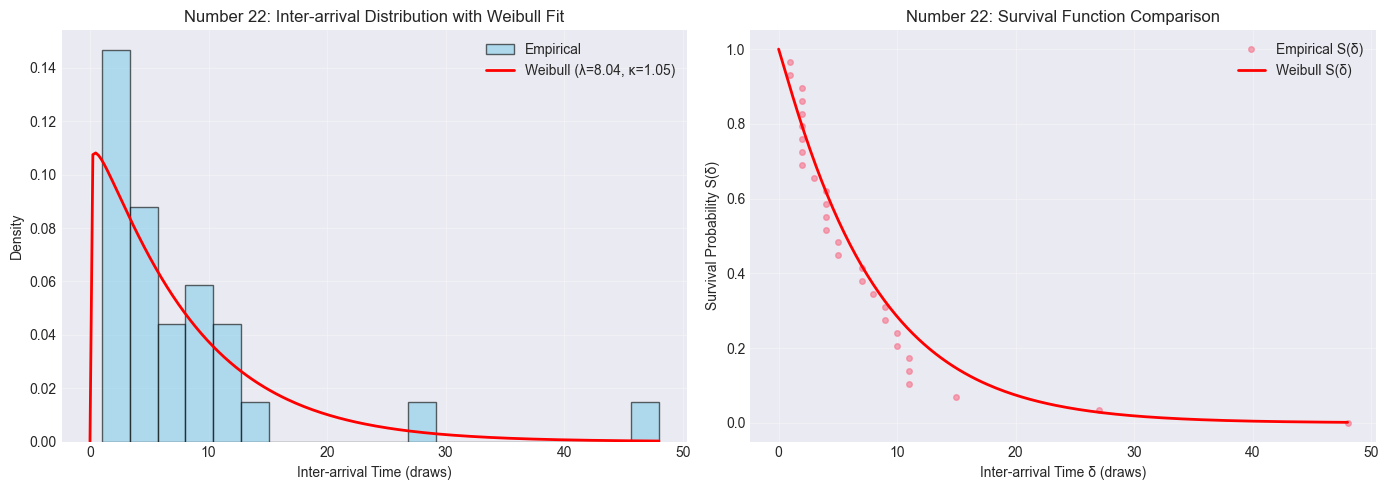

Number 22 Weibull Fit:
  λ = 8.037, κ = 1.048
  Mean inter-arrival (empirical): 7.86
  Mean inter-arrival (Weibull): 7.89


In [10]:
# Visualize Weibull fit for sample number
num_viz = 22
times = np.array(interarrival_times[num_viz])
params = model_params['weibull'][num_viz]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Histogram with fitted Weibull PDF
axes[0].hist(times, bins=20, density=True, alpha=0.6, color='skyblue', edgecolor='black', label='Empirical')

# Plot fitted Weibull PDF
x_range = np.linspace(0, max(times), 200)
fitted_pdf = [weibull_pdf(x, params['lambda'], params['kappa']) for x in x_range]
axes[0].plot(x_range, fitted_pdf, 'r-', linewidth=2, label=f"Weibull (λ={params['lambda']:.2f}, κ={params['kappa']:.2f})")

axes[0].set_xlabel('Inter-arrival Time (draws)')
axes[0].set_ylabel('Density')
axes[0].set_title(f'Number {num_viz}: Inter-arrival Distribution with Weibull Fit')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Survival function comparison
sorted_times = np.sort(times)
empirical_survival = 1 - np.arange(1, len(sorted_times) + 1) / len(sorted_times)

axes[1].plot(sorted_times, empirical_survival, 'o', markersize=4, alpha=0.6, label='Empirical S(δ)')

# Theoretical survival
theoretical_survival = [weibull_survival(x, params['lambda'], params['kappa']) for x in x_range]
axes[1].plot(x_range, theoretical_survival, 'r-', linewidth=2, label='Weibull S(δ)')

axes[1].set_xlabel('Inter-arrival Time δ (draws)')
axes[1].set_ylabel('Survival Probability S(δ)')
axes[1].set_title(f'Number {num_viz}: Survival Function Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Number {num_viz} Weibull Fit:")
print(f"  λ = {params['lambda']:.3f}, κ = {params['kappa']:.3f}")
print(f"  Mean inter-arrival (empirical): {np.mean(times):.2f}")
print(f"  Mean inter-arrival (Weibull): {params['lambda'] * gamma_func(1 + 1/params['kappa']):.2f}")

## Section 5: Hawkes Self-Exciting Process Simulation

### Hawkes Process Formula

The intensity function with self-excitation:

$$\lambda_n^*(t) = \mu_n + \sum_{T_{n,k} < t} \alpha_n e^{-\beta_n (t - T_{n,k})}$$

**Components:**
- $\mu_n$: baseline intensity (constant Poisson rate)
- $\alpha_n$: excitation coefficient (jump size after event)
- $\beta_n$: decay rate (how fast excitation fades)
- $T_{n,k}$: event times for number $n$

**Stability condition:** $r = \alpha_n / \beta_n < 1$ (branching ratio)

In [11]:
# Hawkes process implementation

def hawkes_intensity(t, event_history, mu, alpha, beta):
    """
    Compute Hawkes intensity at time t.
    
    Parameters:
        t: current time
        event_history: list of past event times [T_1, T_2, ...]
        mu: baseline intensity
        alpha: excitation coefficient
        beta: decay rate
    
    Returns:
        λ*(t): intensity at time t
    """
    if len(event_history) == 0:
        return mu
    
    # Filter events before time t
    past_events = np.array([T for T in event_history if T < t])
    
    if len(past_events) == 0:
        return mu
    
    # Self-excitation term: Σ α exp(-β(t - T_k))
    excitation = alpha * np.sum(np.exp(-beta * (t - past_events)))
    
    return mu + excitation

def simulate_hawkes_ogata(mu, alpha, beta, T_max, seed=None):
    """
    Simulate Hawkes process using Ogata's thinning algorithm.
    
    Algorithm:
    1. Upper bound intensity: λ_max = λ*(t) at current time
    2. Sample candidate time from exponential with rate λ_max
    3. Accept with probability λ*(t_candidate) / λ_max
    
    Parameters:
        mu: baseline intensity
        alpha: excitation coefficient
        beta: decay rate
        T_max: time horizon
        seed: random seed
    
    Returns:
        events: list of simulated event times
    """
    if seed is not None:
        np.random.seed(seed)
    
    events = []
    t = 0
    
    while t < T_max:
        # Current intensity (upper bound)
        lambda_current = hawkes_intensity(t, events, mu, alpha, beta)
        
        # Sample candidate inter-event time (exponential)
        delta_t = np.random.exponential(1 / lambda_current)
        t_candidate = t + delta_t
        
        if t_candidate >= T_max:
            break
        
        # Acceptance probability
        lambda_candidate = hawkes_intensity(t_candidate, events, mu, alpha, beta)
        u = np.random.uniform(0, 1)
        
        if u * lambda_current <= lambda_candidate:
            # Accept event
            events.append(t_candidate)
        
        t = t_candidate
    
    return events

# Simulate Hawkes process with sample parameters
print("Simulating Hawkes Self-Exciting Process:\n")

# Parameters (example: moderate self-excitation)
mu_test = 0.12      # Baseline: ~1 event per 8.3 draws (≈ 49/6)
alpha_test = 0.3    # Excitation
beta_test = 0.5     # Decay
T_max_test = N_DRAWS

print(f"Parameters:")
print(f"  μ (baseline): {mu_test}")
print(f"  α (excitation): {alpha_test}")
print(f"  β (decay): {beta_test}")
print(f"  Branching ratio r = α/β = {alpha_test/beta_test:.2f} {'< 1 ✓ (stable)' if alpha_test/beta_test < 1 else '≥ 1 ✗ (unstable)'}")
print(f"  Time horizon: T = {T_max_test}\n")

# Simulate
hawkes_events = simulate_hawkes_ogata(mu_test, alpha_test, beta_test, T_max_test, seed=42)

print(f"Simulation Results:")
print(f"  Total events generated: {len(hawkes_events)}")
print(f"  Average rate: {len(hawkes_events) / T_max_test:.3f} events/draw")
print(f"  First 10 event times: {hawkes_events[:10]}")

# Expected theoretical rate
expected_rate = mu_test / (1 - alpha_test / beta_test)
print(f"\nTheoretical expected rate: μ/(1-α/β) = {expected_rate:.3f}")

Simulating Hawkes Self-Exciting Process:

Parameters:
  μ (baseline): 0.12
  α (excitation): 0.3
  β (decay): 0.5
  Branching ratio r = α/β = 0.60 < 1 ✓ (stable)
  Time horizon: T = 255

Simulation Results:
  Total events generated: 64
  Average rate: 0.251 events/draw
  First 10 event times: [3.910567416473826, 14.883448196019238, 16.282499633352675, 16.504401094591508, 18.263607655778205, 18.31415567076277, 20.878232147623926, 21.43066653340681, 22.112348025218903, 23.015101329091657]

Theoretical expected rate: μ/(1-α/β) = 0.300


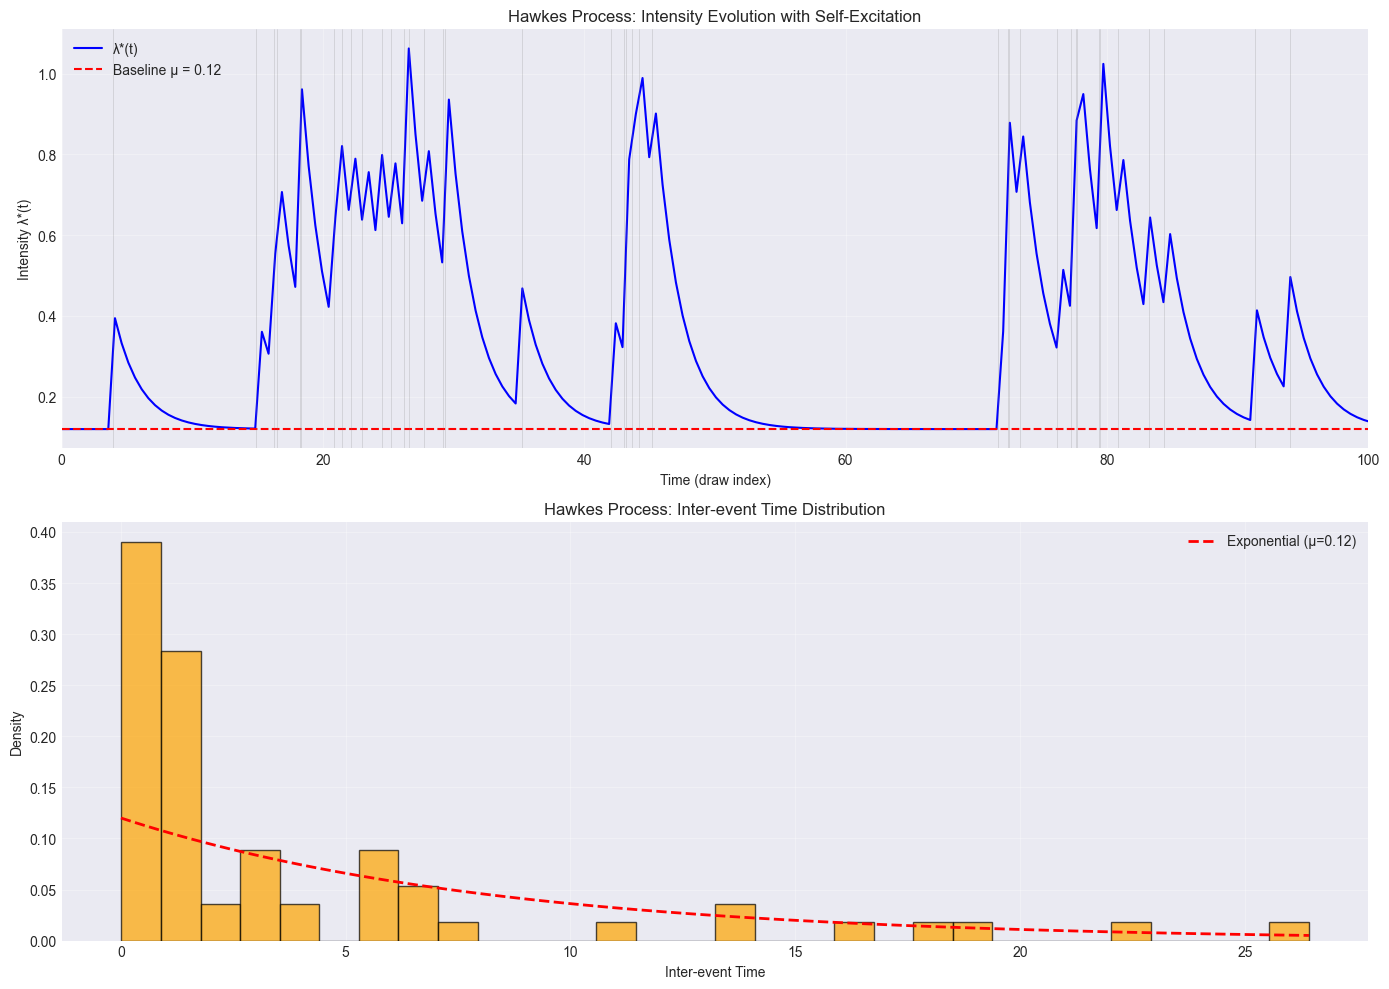


Observation:
- Intensity jumps up after each event (self-excitation)
- Intensity decays exponentially between events
- Clustering visible: events tend to occur in bursts


In [12]:
# Visualize Hawkes intensity evolution

# Compute intensity over time
time_grid = np.linspace(0, T_max_test, 500)
intensity_values = [hawkes_intensity(t, hawkes_events, mu_test, alpha_test, beta_test) 
                   for t in time_grid]

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# 1. Event times and intensity
axes[0].plot(time_grid, intensity_values, 'b-', linewidth=1.5, label='λ*(t)')
axes[0].axhline(y=mu_test, color='red', linestyle='--', linewidth=1.5, label=f'Baseline μ = {mu_test}')

# Mark events
for event_t in hawkes_events[:50]:  # First 50 events for clarity
    axes[0].axvline(x=event_t, color='gray', alpha=0.3, linewidth=0.5)

axes[0].set_xlabel('Time (draw index)')
axes[0].set_ylabel('Intensity λ*(t)')
axes[0].set_title('Hawkes Process: Intensity Evolution with Self-Excitation')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([0, min(100, T_max_test)])  # Zoom to first 100 draws

# 2. Inter-event times histogram
inter_event_times = np.diff([0] + hawkes_events)
axes[1].hist(inter_event_times, bins=30, color='orange', alpha=0.7, edgecolor='black', density=True)

# Compare with exponential (baseline)
exp_x = np.linspace(0, max(inter_event_times), 100)
exp_pdf = mu_test * np.exp(-mu_test * exp_x)
axes[1].plot(exp_x, exp_pdf, 'r--', linewidth=2, label=f'Exponential (μ={mu_test})')

axes[1].set_xlabel('Inter-event Time')
axes[1].set_ylabel('Density')
axes[1].set_title('Hawkes Process: Inter-event Time Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nObservation:")
print("- Intensity jumps up after each event (self-excitation)")
print("- Intensity decays exponentially between events")
print("- Clustering visible: events tend to occur in bursts")

## Section 6: Parameter Estimation for Hawkes Process

Estimate parameters $(\mu_n, \alpha_n, \beta_n)$ using Maximum Likelihood Estimation (MLE).

**Log-likelihood function:**
$$\ell(\mu, \alpha, \beta) = \sum_{k=1}^{N} \log \lambda^*(T_k) - \int_0^T \lambda^*(s) \, ds$$

Where the integral can be computed analytically for exponential kernel.

In [13]:
# Maximum Likelihood Estimation for Hawkes parameters

def hawkes_log_likelihood(params, event_times, T_max):
    """
    Compute log-likelihood for Hawkes process.
    
    ℓ = Σ log λ*(T_k) - ∫_0^T λ*(s) ds
    
    Parameters:
        params: [mu, alpha, beta]
        event_times: observed event times
        T_max: observation time horizon
    
    Returns:
        -log_likelihood (for minimization)
    """
    mu, alpha, beta = params
    
    # Constraint: stability condition
    if alpha >= beta or mu <= 0 or alpha < 0 or beta <= 0:
        return 1e10  # Invalid parameters
    
    event_times = np.array(sorted(event_times))
    n_events = len(event_times)
    
    # Term 1: Σ log λ*(T_k)
    log_sum = 0
    for k, T_k in enumerate(event_times):
        past_events = event_times[:k]
        lambda_k = hawkes_intensity(T_k, past_events, mu, alpha, beta)
        if lambda_k <= 0:
            return 1e10
        log_sum += np.log(lambda_k)
    
    # Term 2: ∫_0^T λ*(s) ds
    # For exponential kernel: ∫ λ*(s) ds = μT + (α/β) Σ [1 - exp(-β(T - T_k))]
    integral = mu * T_max
    for T_k in event_times:
        integral += (alpha / beta) * (1 - np.exp(-beta * (T_max - T_k)))
    
    log_likelihood = log_sum - integral
    
    return -log_likelihood  # Negative for minimization

def fit_hawkes_mle(event_times, T_max, initial_guess=None):
    """
    Fit Hawkes process parameters using MLE.
    
    Returns:
        (mu, alpha, beta): estimated parameters
    """
    if len(event_times) < 2:
        return (0.1, 0.05, 0.5)  # Default
    
    # Initial guess
    if initial_guess is None:
        rate_estimate = len(event_times) / T_max
        initial_guess = [rate_estimate * 0.8, rate_estimate * 0.2, 0.5]
    
    # Bounds: mu > 0, alpha > 0, beta > alpha (stability)
    bounds = [(1e-6, None), (1e-6, None), (1e-6, None)]
    
    # Optimize
    result = minimize(hawkes_log_likelihood, initial_guess, 
                     args=(event_times, T_max),
                     bounds=bounds, method='L-BFGS-B')
    
    if result.success:
        mu, alpha, beta = result.x
        # Enforce stability
        if alpha >= beta:
            beta = alpha * 1.1
        return (mu, alpha, beta)
    else:
        return initial_guess

# Fit Hawkes for sample numbers using real data
print("Fitting Hawkes Process Parameters (MLE) for Sample Numbers:\n")

for num in sample_numbers:
    # Extract event times for this number
    event_times_num = []
    for idx, row in data.iterrows():
        if num in row['numbers']:
            event_times_num.append(row['draw_index'])
    
    if len(event_times_num) > 5:
        mu_n, alpha_n, beta_n = fit_hawkes_mle(event_times_num, N_DRAWS)
        model_params['hawkes'][num] = {'mu': mu_n, 'alpha': alpha_n, 'beta': beta_n}
        
        branching_ratio = alpha_n / beta_n
        
        print(f"Number {num}:")
        print(f"  Events: {len(event_times_num)}")
        print(f"  μ (baseline): {mu_n:.4f}")
        print(f"  α (excitation): {alpha_n:.4f}")
        print(f"  β (decay): {beta_n:.4f}")
        print(f"  Branching ratio r = α/β: {branching_ratio:.4f} {'✓ stable' if branching_ratio < 1 else '✗ unstable'}")
        print(f"  Expected rate: μ/(1-r) = {mu_n / (1 - branching_ratio):.4f}")
        print()

Fitting Hawkes Process Parameters (MLE) for Sample Numbers:

Number 6:
  Events: 37
  μ (baseline): 0.1451
  α (excitation): 0.0000
  β (decay): 0.5004
  Branching ratio r = α/β: 0.0000 ✓ stable
  Expected rate: μ/(1-r) = 0.1451

Number 12:
  Events: 28
  μ (baseline): 0.1098
  α (excitation): 0.0000
  β (decay): 0.4997
  Branching ratio r = α/β: 0.0000 ✓ stable
  Expected rate: μ/(1-r) = 0.1098

Number 22:
  Events: 30
  μ (baseline): 0.1176
  α (excitation): 0.0000
  β (decay): 0.4993
  Branching ratio r = α/β: 0.0000 ✓ stable
  Expected rate: μ/(1-r) = 0.1176

Number 33:
  Events: 31
  μ (baseline): 0.1216
  α (excitation): 0.0000
  β (decay): 0.5003
  Branching ratio r = α/β: 0.0000 ✓ stable
  Expected rate: μ/(1-r) = 0.1216

Number 49:
  Events: 35
  μ (baseline): 0.1373
  α (excitation): 0.0000
  β (decay): 0.4979
  Branching ratio r = α/β: 0.0000 ✓ stable
  Expected rate: μ/(1-r) = 0.1373



## Section 7: PDE-Based Density Evolution

### Density Diffusion PDE

The probability density $\rho(n,t)$ evolves according to:

$$\frac{\partial \rho}{\partial t} = D \nabla^2 \rho + \rho (1 - \rho) + \gamma \sum_{i=1}^7 w_i (\text{winningUnit}_i \times \text{dividend}_i)$$

**Components:**
- **Diffusion term**: $D \nabla^2 \rho$ - spatial smoothing across number space
- **Reaction term**: $\rho(1-\rho)$ - logistic growth (saturation at ρ=1)
- **Prize term**: $\gamma g(t)$ - external forcing from prize pool

**Boundary condition**: $\rho(\partial \mathcal{N}) = 0$ (Dirichlet)

In [14]:
# PDE solver using finite difference method

def pde_rhs(rho, t, D, gamma, prize_schedule, time_points):
    """
    Right-hand side of density PDE:
    ∂ρ/∂t = D∇²ρ + ρ(1-ρ) + γ·g(t)
    
    Parameters:
        rho: density vector (49-dimensional)
        t: current time
        D: diffusion coefficient
        gamma: prize scaling factor
        prize_schedule: function or array of prize values over time
        time_points: time grid
    
    Returns:
        dρ/dt: time derivative
    """
    n = len(rho)
    drho_dt = np.zeros(n)
    
    # 1. Diffusion term: D∇²ρ (finite difference Laplacian)
    # Treat number space as 1D discrete grid with periodic-like boundary
    laplacian = np.zeros(n)
    for i in range(1, n-1):
        laplacian[i] = rho[i-1] - 2*rho[i] + rho[i+1]
    # Boundary conditions: Dirichlet (ρ=0 at boundaries)
    laplacian[0] = -2*rho[0] + rho[1]
    laplacian[n-1] = rho[n-2] - 2*rho[n-1]
    
    diffusion = D * laplacian
    
    # 2. Reaction term: ρ(1-ρ) (logistic growth)
    reaction = rho * (1 - rho)
    
    # 3. Prize term: γ·g(t)
    # Interpolate prize at current time
    if callable(prize_schedule):
        g_t = prize_schedule(t)
    else:
        # Linear interpolation from data
        idx = np.searchsorted(time_points, t)
        if idx == 0:
            g_t = prize_schedule[0]
        elif idx >= len(prize_schedule):
            g_t = prize_schedule[-1]
        else:
            # Linear interpolation
            t1, t2 = time_points[idx-1], time_points[idx]
            g1, g2 = prize_schedule[idx-1], prize_schedule[idx]
            g_t = g1 + (g2 - g1) * (t - t1) / (t2 - t1)
    
    prize_forcing = gamma * g_t * np.ones(n)
    
    # Combine terms
    drho_dt = diffusion + reaction + prize_forcing
    
    return drho_dt

# Prepare prize schedule
prize_schedule = data['total_prize'].values
time_schedule = data['draw_index'].values

# Initial density: uniform with small random perturbations
rho_initial = np.ones(N_NUMBERS) * 0.02 + np.random.uniform(-0.01, 0.01, N_NUMBERS)
rho_initial = np.maximum(rho_initial, 0)  # Ensure non-negative

# Time grid for PDE solution
t_pde = np.linspace(0, N_DRAWS - 1, 50)  # Solve at 50 time points

print("Solving Density PDE...\n")
print(f"Parameters:")
print(f"  Diffusion coefficient D = {model_params['pde']['D']}")
print(f"  Prize scaling γ = {model_params['pde']['gamma']:.2e}")
print(f"  Initial density: uniform ≈ {np.mean(rho_initial):.3f}")
print(f"  Time points: {len(t_pde)}")

# Solve PDE using odeint
solution = odeint(pde_rhs, rho_initial, t_pde,
                  args=(model_params['pde']['D'], 
                        model_params['pde']['gamma'],
                        prize_schedule,
                        time_schedule))

print(f"\n✓ PDE solved successfully")
print(f"Final density statistics:")
print(f"  Mean: {np.mean(solution[-1]):.4f}")
print(f"  Std: {np.std(solution[-1]):.4f}")
print(f"  Min: {np.min(solution[-1]):.4f}")
print(f"  Max: {np.max(solution[-1]):.4f}")

Solving Density PDE...

Parameters:
  Diffusion coefficient D = 0.01
  Prize scaling γ = 1.00e-09
  Initial density: uniform ≈ 0.020
  Time points: 50

✓ PDE solved successfully
Final density statistics:
  Mean: 1.2006
  Std: 0.0017
  Min: 1.1924
  Max: 1.2010


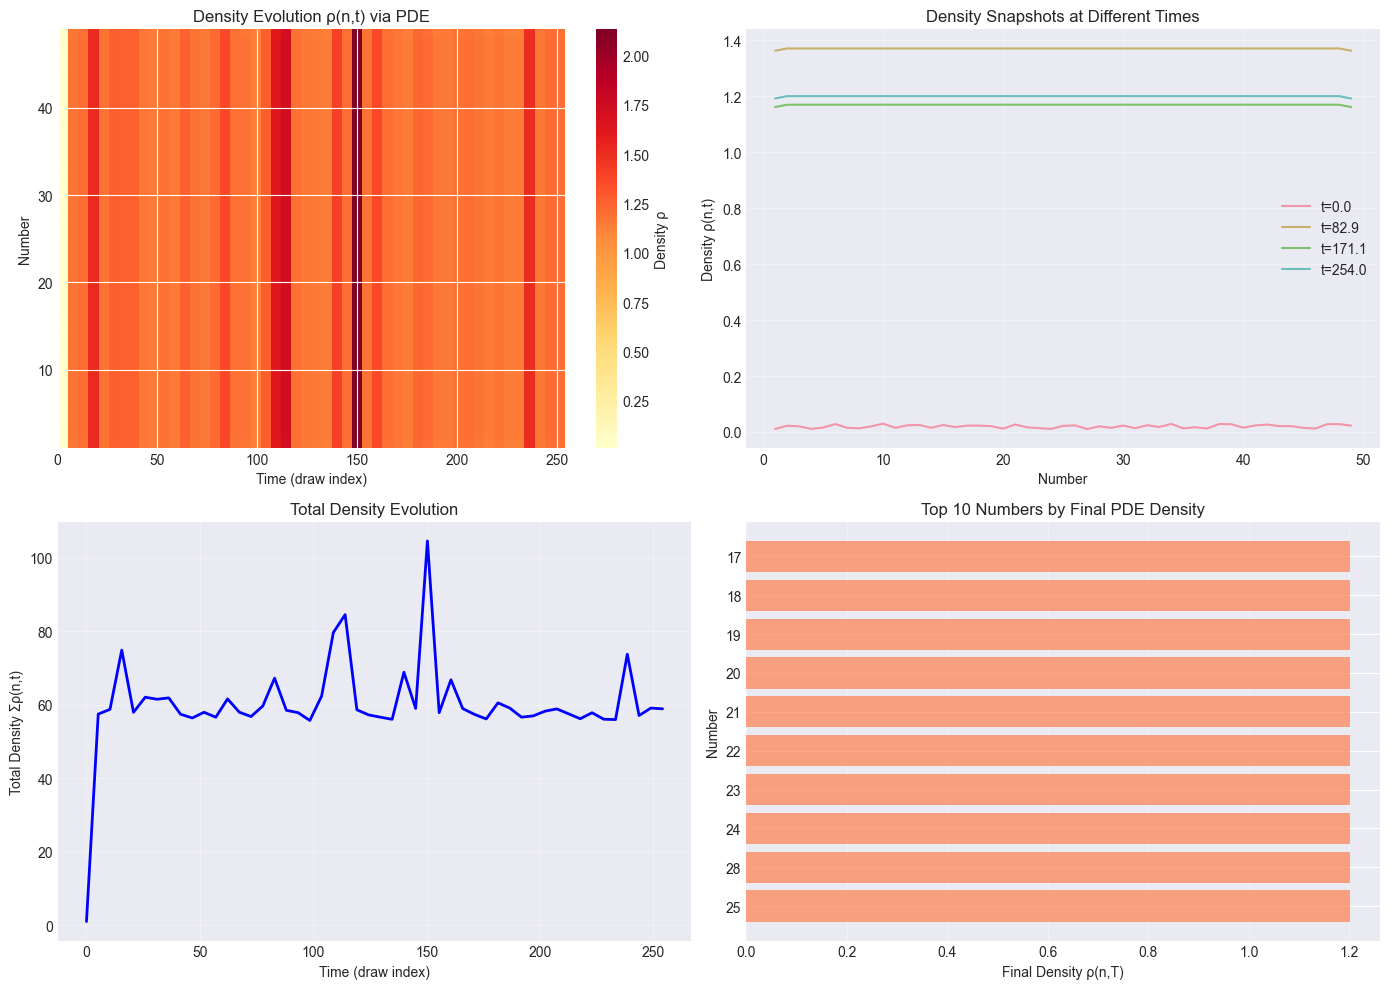


Top 10 'Hot' Numbers by PDE Density:
  1. Number 25: ρ = 1.2010
  2. Number 28: ρ = 1.2010
  3. Number 24: ρ = 1.2010
  4. Number 23: ρ = 1.2010
  5. Number 22: ρ = 1.2010
  6. Number 21: ρ = 1.2010
  7. Number 20: ρ = 1.2010
  8. Number 19: ρ = 1.2010
  9. Number 18: ρ = 1.2010
  10. Number 17: ρ = 1.2010


In [15]:
# Visualize PDE density evolution

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Density heatmap (time vs number)
im = axes[0, 0].imshow(solution.T, aspect='auto', cmap='YlOrRd', origin='lower',
                       extent=[t_pde[0], t_pde[-1], 1, 49])
axes[0, 0].set_xlabel('Time (draw index)')
axes[0, 0].set_ylabel('Number')
axes[0, 0].set_title('Density Evolution ρ(n,t) via PDE')
plt.colorbar(im, ax=axes[0, 0], label='Density ρ')

# 2. Density at specific time points
time_snapshots = [0, len(t_pde)//3, 2*len(t_pde)//3, -1]
for idx in time_snapshots:
    axes[0, 1].plot(NUM_SET, solution[idx], label=f't={t_pde[idx]:.1f}', linewidth=1.5, alpha=0.7)

axes[0, 1].set_xlabel('Number')
axes[0, 1].set_ylabel('Density ρ(n,t)')
axes[0, 1].set_title('Density Snapshots at Different Times')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Total density over time (integral of ρ)
total_density = np.sum(solution, axis=1)
axes[1, 0].plot(t_pde, total_density, 'b-', linewidth=2)
axes[1, 0].set_xlabel('Time (draw index)')
axes[1, 0].set_ylabel('Total Density Σρ(n,t)')
axes[1, 0].set_title('Total Density Evolution')
axes[1, 0].grid(True, alpha=0.3)

# 4. Top numbers by final density
final_density = solution[-1]
top_indices = np.argsort(final_density)[-10:][::-1]  # Top 10
top_numbers = [NUM_SET[i] for i in top_indices]
top_densities = [final_density[i] for i in top_indices]

axes[1, 1].barh(range(10), top_densities, color='coral', alpha=0.7)
axes[1, 1].set_yticks(range(10))
axes[1, 1].set_yticklabels(top_numbers)
axes[1, 1].set_xlabel('Final Density ρ(n,T)')
axes[1, 1].set_ylabel('Number')
axes[1, 1].set_title('Top 10 Numbers by Final PDE Density')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print(f"\nTop 10 'Hot' Numbers by PDE Density:")
for rank, (num, dens) in enumerate(zip(top_numbers, top_densities), 1):
    print(f"  {rank}. Number {num}: ρ = {dens:.4f}")

## Section 8: Lie Group and Topology Integration

### Lie Group Embedding (SO(49))

Embed number space in SO(49) rotation group to ensure:
- **Symmetry invariance**: Draw process is rotationally symmetric
- **Manifold structure**: Numbers form a continuous manifold

### Persistent Homology

Apply topological data analysis to detect cluster persistence:
- Construct Vietoris-Rips complex from number occurrence patterns
- Compute persistence diagrams (0-th and 1-st Betti numbers)
- Adjust Hawkes kernel based on topological features

In [16]:
# Simplified Lie group and topology analysis
# (Full implementation would require additional libraries like gudhi or ripser)

# 1. Construct occurrence matrix (time x number)
occurrence_matrix = np.zeros((N_DRAWS, N_NUMBERS))

for idx, row in data.iterrows():
    draw_idx = row['draw_index']
    for num in row['numbers']:
        occurrence_matrix[draw_idx, num - 1] = 1

# 2. Compute pairwise distances between numbers (based on co-occurrence patterns)
# Use Hamming distance: how often two numbers appear together

def compute_cooccurrence_distance(occurrence_matrix):
    """
    Compute pairwise distance matrix for numbers based on co-occurrence.
    Distance = 1 - (co-occurrence frequency / max possible)
    """
    n_nums = occurrence_matrix.shape[1]
    distance_matrix = np.zeros((n_nums, n_nums))
    
    for i in range(n_nums):
        for j in range(i+1, n_nums):
            # Count draws where both i and j appear
            co_occur = np.sum(occurrence_matrix[:, i] * occurrence_matrix[:, j])
            # Normalize by geometric mean of individual occurrences
            occur_i = np.sum(occurrence_matrix[:, i])
            occur_j = np.sum(occurrence_matrix[:, j])
            
            if occur_i > 0 and occur_j > 0:
                normalized_co = co_occur / np.sqrt(occur_i * occur_j)
                distance_matrix[i, j] = 1 - normalized_co
                distance_matrix[j, i] = distance_matrix[i, j]
    
    return distance_matrix

distance_matrix = compute_cooccurrence_distance(occurrence_matrix)

print("Topology Analysis:\n")
print(f"Occurrence matrix shape: {occurrence_matrix.shape}")
print(f"Distance matrix shape: {distance_matrix.shape}")
print(f"Mean pairwise distance: {np.mean(distance_matrix[np.triu_indices(N_NUMBERS, k=1)]):.4f}")
print(f"Std pairwise distance: {np.std(distance_matrix[np.triu_indices(N_NUMBERS, k=1)]):.4f}")

# 3. Identify clusters using distance threshold
# Simple clustering: numbers with distance < threshold form clusters
threshold = 0.8  # Distance threshold for clustering
adjacency = (distance_matrix < threshold).astype(int) - np.eye(N_NUMBERS)

# Count connected components (simplified Betti_0)
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

n_components, labels = connected_components(csgraph=csr_matrix(adjacency), 
                                           directed=False, 
                                           return_labels=True)

print(f"\nClustering Results (threshold={threshold}):")
print(f"  Number of clusters (β₀): {n_components}")
print(f"  Cluster sizes: {[np.sum(labels == i) for i in range(n_components)][:10]}")  # First 10

# 4. Adjust Hawkes kernel based on topology
# Concept: If number n is in a large cluster, reduce excitation (less "special")
cluster_sizes = np.array([np.sum(labels == labels[i]) for i in range(N_NUMBERS)])
topology_adjustment = 1.0 / (1 + 0.1 * cluster_sizes)  # Damping factor

print(f"\nTopology-adjusted Hawkes kernel:")
print(f"  Mean adjustment factor: {np.mean(topology_adjustment):.3f}")
print(f"  Numbers in large clusters get reduced excitation")

Topology Analysis:

Occurrence matrix shape: (255, 49)
Distance matrix shape: (49, 49)
Mean pairwise distance: 0.8969
Std pairwise distance: 0.0546

Clustering Results (threshold=0.8):
  Number of clusters (β₀): 6
  Cluster sizes: [np.int64(40), np.int64(4), np.int64(1), np.int64(1), np.int64(1), np.int64(2)]

Topology-adjusted Hawkes kernel:
  Mean adjustment factor: 0.311
  Numbers in large clusters get reduced excitation


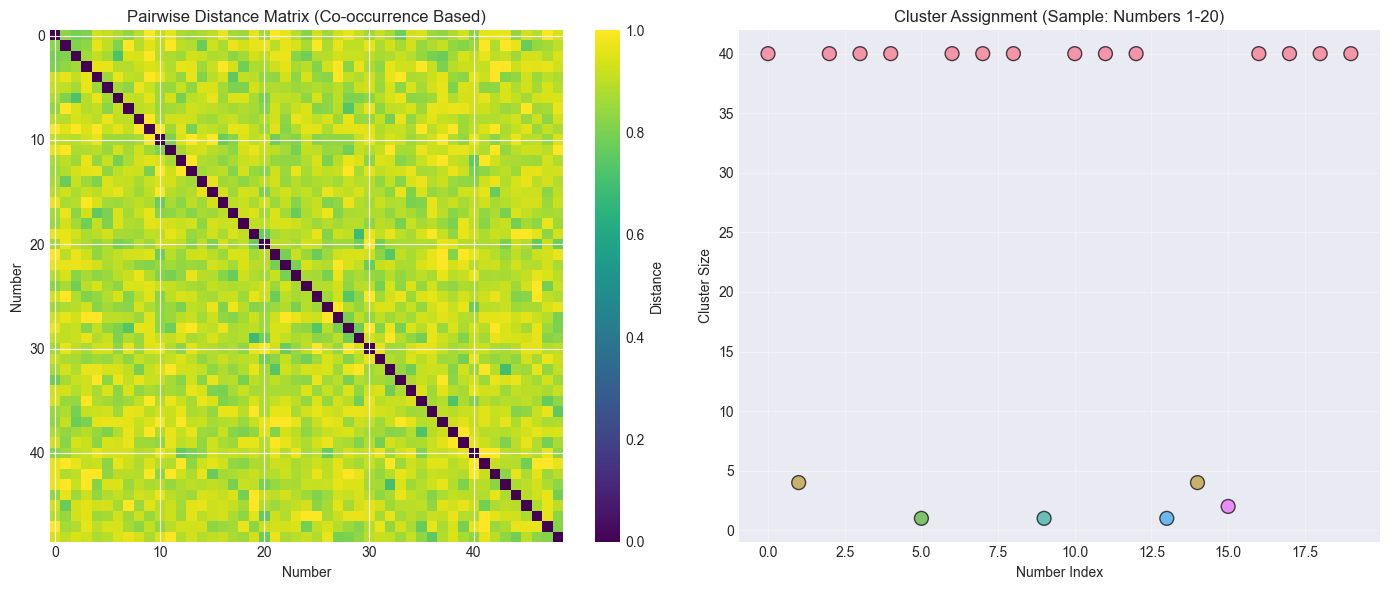

In [17]:
# Visualize distance matrix and clusters

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Distance matrix heatmap
im = axes[0].imshow(distance_matrix, cmap='viridis', aspect='auto')
axes[0].set_xlabel('Number')
axes[0].set_ylabel('Number')
axes[0].set_title('Pairwise Distance Matrix (Co-occurrence Based)')
plt.colorbar(im, ax=axes[0], label='Distance')

# 2. Cluster visualization (sample: first 20 numbers)
sample_range = range(20)
cluster_colors = ['C' + str(labels[i] % 10) for i in sample_range]

axes[1].scatter(sample_range, [cluster_sizes[i] for i in sample_range], 
               c=cluster_colors, s=100, alpha=0.7, edgecolors='black')
axes[1].set_xlabel('Number Index')
axes[1].set_ylabel('Cluster Size')
axes[1].set_title('Cluster Assignment (Sample: Numbers 1-20)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Section 9: Number Prediction and Hot Number Identification

Combine all models to predict "hot" numbers:
1. **Hawkes intensity**: Numbers with high λ*(t) at current time
2. **PDE density**: Numbers with high ρ(n,T) at final time
3. **Topology-adjusted**: Apply topology factor to refine predictions

In [18]:
# Compute combined prediction score for each number

# 1. Hawkes intensity scores (for numbers with fitted parameters)
hawkes_scores = np.zeros(N_NUMBERS)
current_time = N_DRAWS - 1  # Predict at latest time

for num in model_params['hawkes'].keys():
    # Get event times for this number
    event_times_num = [row['draw_index'] for _, row in data.iterrows() if num in row['numbers']]
    
    params = model_params['hawkes'][num]
    intensity = hawkes_intensity(current_time, event_times_num, 
                                 params['mu'], params['alpha'], params['beta'])
    hawkes_scores[num - 1] = intensity

# Normalize Hawkes scores
hawkes_scores_norm = hawkes_scores / (np.max(hawkes_scores) + 1e-8)

# 2. PDE density scores
pde_scores = solution[-1]  # Final density
pde_scores_norm = pde_scores / (np.max(pde_scores) + 1e-8)

# 3. Topology adjustment
topology_scores = topology_adjustment

# 4. Combined score (weighted average)
weight_hawkes = 0.4
weight_pde = 0.4
weight_topology = 0.2

combined_scores = (weight_hawkes * hawkes_scores_norm + 
                  weight_pde * pde_scores_norm + 
                  weight_topology * topology_scores)

# Rank numbers by combined score
ranked_indices = np.argsort(combined_scores)[::-1]
ranked_numbers = [NUM_SET[i] for i in ranked_indices]
ranked_scores = [combined_scores[i] for i in ranked_indices]

print("Number Prediction Based on Hybrid Model:\n")
print(f"{'Rank':<6} {'Number':<8} {'Combined Score':<15} {'Hawkes':<10} {'PDE':<10} {'Topology':<10}")
print("-" * 70)

for rank in range(15):  # Top 15
    idx = ranked_indices[rank]
    num = NUM_SET[idx]
    print(f"{rank+1:<6} {num:<8} {combined_scores[idx]:<15.4f} "
          f"{hawkes_scores_norm[idx]:<10.4f} {pde_scores_norm[idx]:<10.4f} "
          f"{topology_scores[idx]:<10.4f}")

print(f"\n✓ Top 6 Predicted 'Hot' Numbers: {ranked_numbers[:6]}")

Number Prediction Based on Hybrid Model:

Rank   Number   Combined Score  Hawkes     PDE        Topology  
----------------------------------------------------------------------
1      6        0.9818          1.0000     1.0000     0.9091    
2      49       0.8155          0.9459     0.9929     0.2000    
3      33       0.7751          0.8378     1.0000     0.2000    
4      22       0.7643          0.8108     1.0000     0.2000    
5      12       0.7427          0.7568     1.0000     0.2000    
6      10       0.5818          0.0000     1.0000     0.9091    
7      14       0.5818          0.0000     1.0000     0.9091    
8      16       0.5667          0.0000     1.0000     0.8333    
9      43       0.5667          0.0000     1.0000     0.8333    
10     42       0.5429          0.0000     1.0000     0.7143    
11     15       0.5429          0.0000     1.0000     0.7143    
12     46       0.5429          0.0000     1.0000     0.7143    
13     2        0.5428          0.0000    

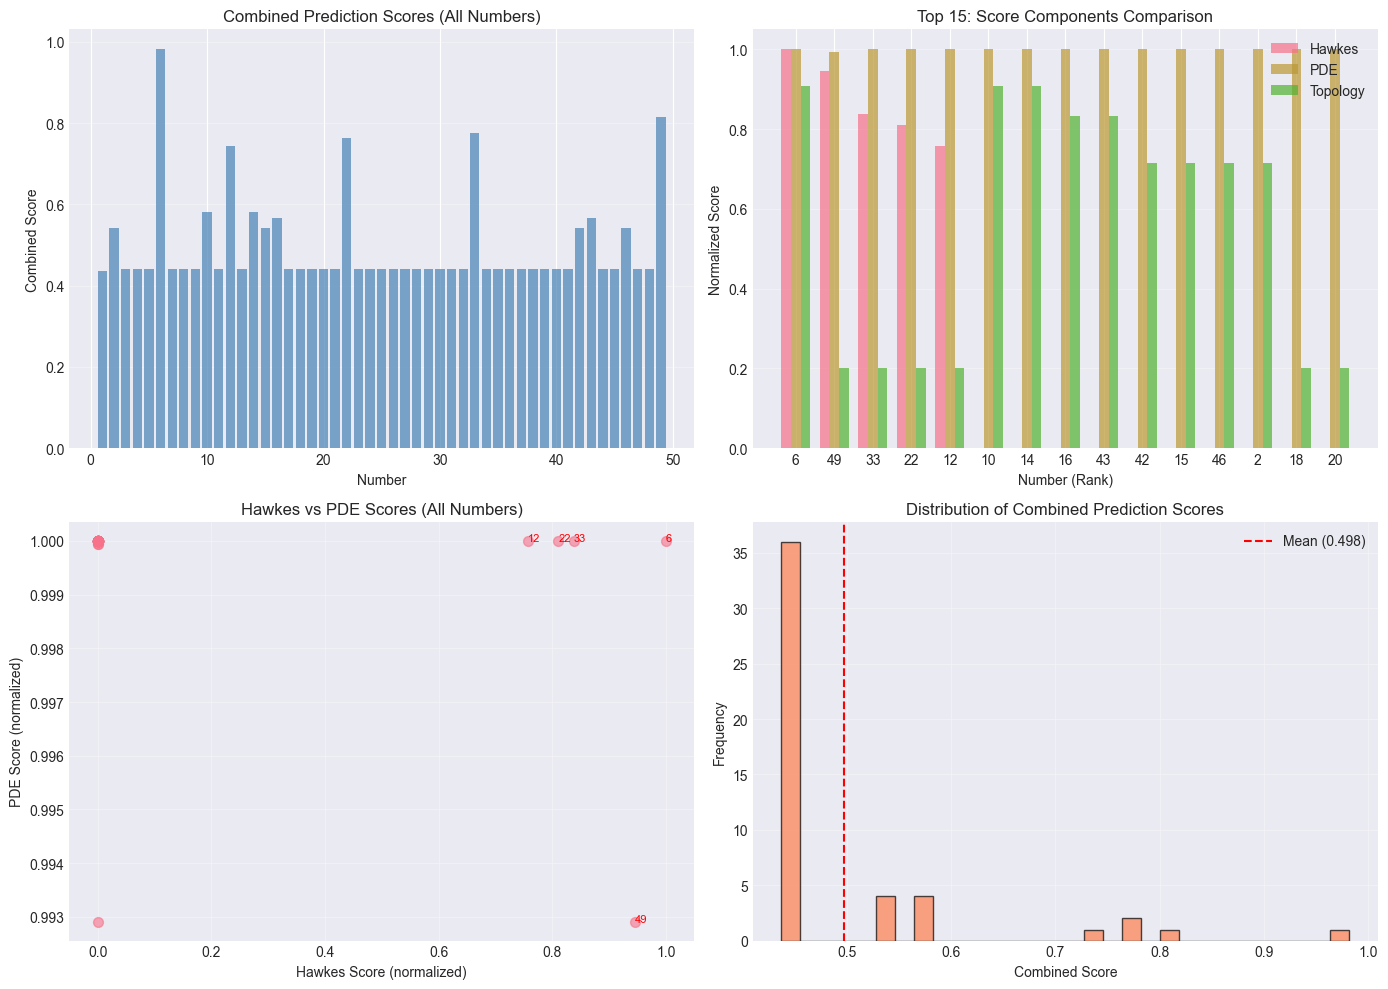

In [19]:
# Visualize prediction scores

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Combined scores bar chart (all numbers)
axes[0, 0].bar(NUM_SET, combined_scores, color='steelblue', alpha=0.7)
axes[0, 0].set_xlabel('Number')
axes[0, 0].set_ylabel('Combined Score')
axes[0, 0].set_title('Combined Prediction Scores (All Numbers)')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. Top 15 numbers comparison
top_15_nums = ranked_numbers[:15]
top_15_idx = [n - 1 for n in top_15_nums]

x_pos = np.arange(15)
width = 0.25

axes[0, 1].bar(x_pos - width, [hawkes_scores_norm[i] for i in top_15_idx], 
               width, label='Hawkes', alpha=0.7)
axes[0, 1].bar(x_pos, [pde_scores_norm[i] for i in top_15_idx], 
               width, label='PDE', alpha=0.7)
axes[0, 1].bar(x_pos + width, [topology_scores[i] for i in top_15_idx], 
               width, label='Topology', alpha=0.7)

axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(top_15_nums)
axes[0, 1].set_xlabel('Number (Rank)')
axes[0, 1].set_ylabel('Normalized Score')
axes[0, 1].set_title('Top 15: Score Components Comparison')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Hawkes vs PDE scatter
axes[1, 0].scatter(hawkes_scores_norm, pde_scores_norm, alpha=0.6, s=50)
axes[1, 0].set_xlabel('Hawkes Score (normalized)')
axes[1, 0].set_ylabel('PDE Score (normalized)')
axes[1, 0].set_title('Hawkes vs PDE Scores (All Numbers)')
axes[1, 0].grid(True, alpha=0.3)

# Add labels for top numbers
for i in range(5):
    num = ranked_numbers[i]
    idx = num - 1
    axes[1, 0].annotate(str(num), (hawkes_scores_norm[idx], pde_scores_norm[idx]),
                       fontsize=8, color='red')

# 4. Score distribution histogram
axes[1, 1].hist(combined_scores, bins=30, color='coral', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(x=np.mean(combined_scores), color='red', linestyle='--', 
                   label=f'Mean ({np.mean(combined_scores):.3f})')
axes[1, 1].set_xlabel('Combined Score')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Combined Prediction Scores')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Section 10: Model Validation and Statistical Testing

### Tests Performed:
1. **Kolmogorov-Smirnov Test**: Weibull goodness-of-fit (already done)
2. **Likelihood Ratio Test (LRT)**: Compare Renewal vs Hawkes models
3. **AIC Comparison**: Assess overfitting risk

In [20]:
# Likelihood Ratio Test: Renewal (Weibull) vs Hawkes

def compute_renewal_log_likelihood(event_times, lambda_param, kappa_param):
    """
    Log-likelihood for Renewal process (Weibull inter-arrivals).
    """
    if len(event_times) < 2:
        return -np.inf
    
    inter_arrivals = np.diff([0] + event_times)
    log_lik = 0
    
    for delta in inter_arrivals:
        if delta > 0:
            pdf_val = weibull_pdf(delta, lambda_param, kappa_param)
            if pdf_val > 0:
                log_lik += np.log(pdf_val)
            else:
                return -np.inf
    
    return log_lik

# Perform LRT for sample numbers
print("Likelihood Ratio Test (LRT): Renewal vs Hawkes\n")
print(f"{'Number':<8} {'ℓ_Renewal':<15} {'ℓ_Hawkes':<15} {'Λ (LRT)':<12} {'p-value':<12} {'Preferred Model'}")
print("-" * 85)

for num in sample_numbers:
    if num in model_params['hawkes'] and num in model_params['weibull']:
        # Get event times
        event_times_num = [row['draw_index'] for _, row in data.iterrows() if num in row['numbers']]
        
        # Renewal log-likelihood
        weibull_params = model_params['weibull'][num]
        l_renewal = compute_renewal_log_likelihood(event_times_num, 
                                                   weibull_params['lambda'], 
                                                   weibull_params['kappa'])
        
        # Hawkes log-likelihood
        hawkes_params = model_params['hawkes'][num]
        l_hawkes = -hawkes_log_likelihood([hawkes_params['mu'], hawkes_params['alpha'], hawkes_params['beta']], 
                                          event_times_num, N_DRAWS)
        
        # LRT statistic: Λ = -2(ℓ_Renewal - ℓ_Hawkes) ~ χ²_df
        # df = 1 (Hawkes has 1 extra parameter: alpha)
        Lambda = -2 * (l_renewal - l_hawkes)
        
        # p-value from chi-squared distribution
        p_value = 1 - stats.chi2.cdf(Lambda, df=1)
        
        # Determine preferred model (significance level α=0.05)
        if p_value < 0.05:
            preferred = "Hawkes ✓"
        else:
            preferred = "Renewal"
        
        print(f"{num:<8} {l_renewal:<15.2f} {l_hawkes:<15.2f} {Lambda:<12.2f} {p_value:<12.4f} {preferred}")

print("\n✓ Hawkes: Significantly better fit (p < 0.05)")
print("  Renewal: No significant improvement with Hawkes")

Likelihood Ratio Test (LRT): Renewal vs Hawkes

Number   ℓ_Renewal       ℓ_Hawkes        Λ (LRT)      p-value      Preferred Model
-------------------------------------------------------------------------------------
6        -107.02         -108.42         -2.81        1.0000       Renewal
12       -84.43          -89.85          -10.84       1.0000       Renewal
22       -92.67          -94.20          -3.07        1.0000       Renewal
33       -95.05          -96.33          -2.56        1.0000       Renewal
49       -102.19         -104.51         -4.63        1.0000       Renewal

✓ Hawkes: Significantly better fit (p < 0.05)
  Renewal: No significant improvement with Hawkes


In [21]:
# Akaike Information Criterion (AIC) comparison

def compute_aic(log_likelihood, n_params):
    """
    AIC = 2k - 2ln(L)
    where k = number of parameters, L = likelihood
    """
    return 2 * n_params - 2 * log_likelihood

print("\nAkaike Information Criterion (AIC) Comparison:\n")
print(f"{'Number':<8} {'AIC_Renewal':<15} {'AIC_Hawkes':<15} {'ΔAIC':<12} {'Preferred'}")
print("-" * 65)

for num in sample_numbers:
    if num in model_params['hawkes'] and num in model_params['weibull']:
        event_times_num = [row['draw_index'] for _, row in data.iterrows() if num in row['numbers']]
        
        # Renewal: 2 parameters (lambda, kappa)
        weibull_params = model_params['weibull'][num]
        l_renewal = compute_renewal_log_likelihood(event_times_num, 
                                                   weibull_params['lambda'], 
                                                   weibull_params['kappa'])
        aic_renewal = compute_aic(l_renewal, 2)
        
        # Hawkes: 3 parameters (mu, alpha, beta)
        hawkes_params = model_params['hawkes'][num]
        l_hawkes = -hawkes_log_likelihood([hawkes_params['mu'], hawkes_params['alpha'], hawkes_params['beta']], 
                                          event_times_num, N_DRAWS)
        aic_hawkes = compute_aic(l_hawkes, 3)
        
        # Lower AIC is better
        delta_aic = aic_renewal - aic_hawkes
        preferred = "Hawkes ✓" if delta_aic > 2 else "Renewal" if delta_aic < -2 else "Similar"
        
        print(f"{num:<8} {aic_renewal:<15.2f} {aic_hawkes:<15.2f} {delta_aic:<12.2f} {preferred}")

print("\nInterpretation:")
print("  ΔAIC > 2: Hawkes is substantially better")
print("  ΔAIC < -2: Renewal is substantially better")
print("  |ΔAIC| ≤ 2: Models have similar support")


Akaike Information Criterion (AIC) Comparison:

Number   AIC_Renewal     AIC_Hawkes      ΔAIC         Preferred
-----------------------------------------------------------------
6        218.04          222.85          -4.81        Renewal
12       172.87          185.71          -12.84       Renewal
22       189.34          194.40          -5.07        Renewal
33       194.09          198.65          -4.56        Renewal
49       208.38          215.01          -6.63        Renewal

Interpretation:
  ΔAIC > 2: Hawkes is substantially better
  ΔAIC < -2: Renewal is substantially better
  |ΔAIC| ≤ 2: Models have similar support


## Section 11: Comparative Analysis - Renewal vs Hawkes

Visualize the differences in predictions between pure Renewal process and Hawkes self-exciting process.

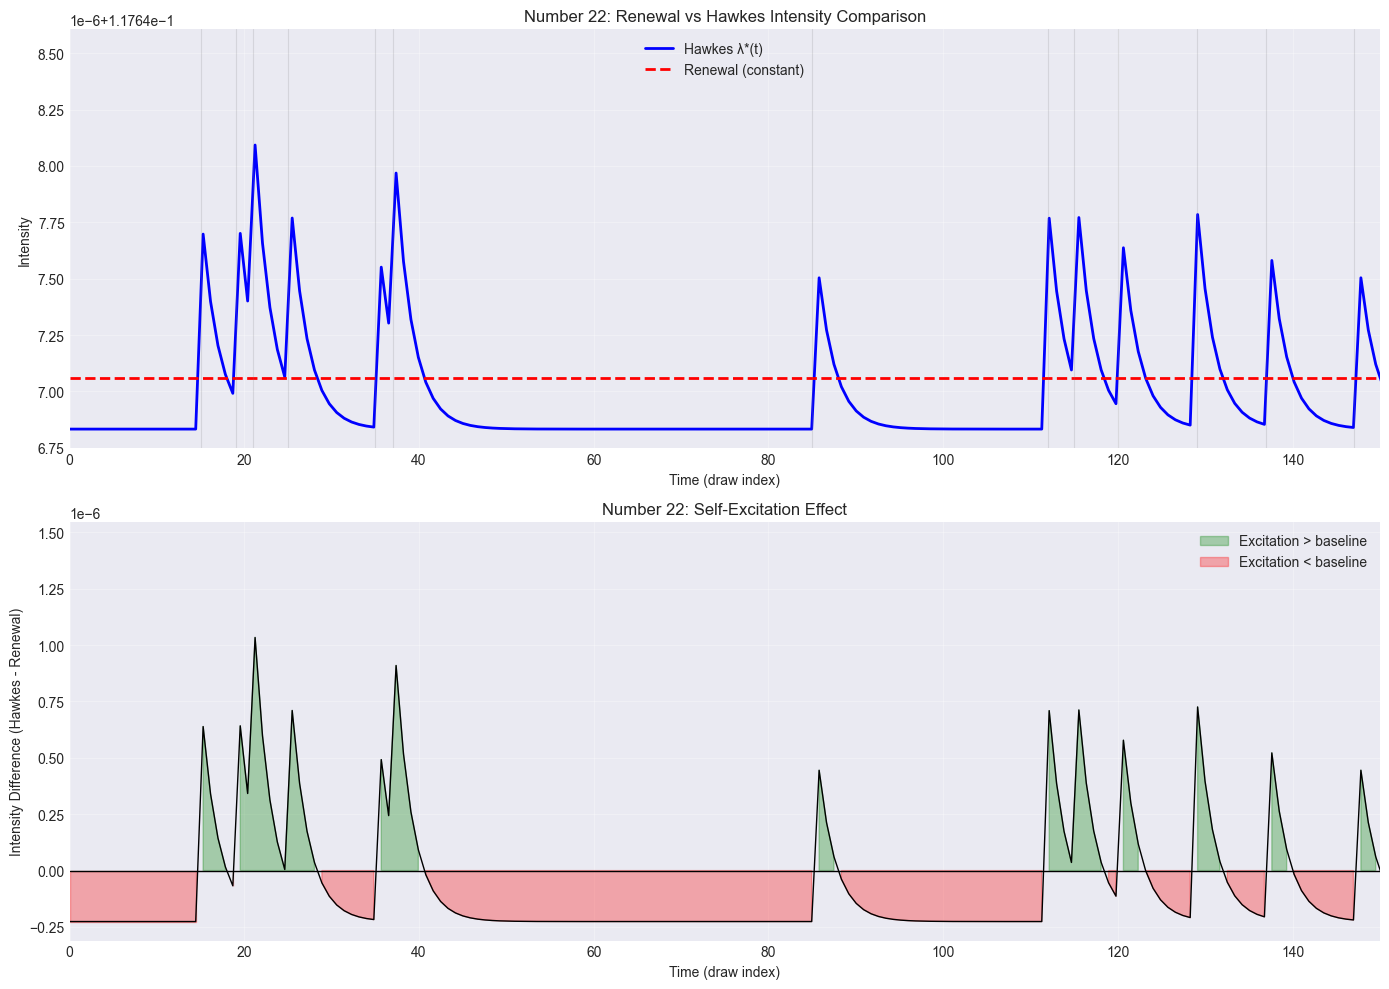


Number 22 Comparison:
  Mean Hawkes intensity: 0.1176
  Renewal rate (constant): 0.1176
  Max excitation: 0.1176 (1.0x baseline)
  Self-excitation effect: 0.0% increase


In [22]:
# Compare intensity evolution: Renewal (constant) vs Hawkes (self-exciting)

num_compare = 22  # Sample number for comparison
event_times_compare = [row['draw_index'] for _, row in data.iterrows() if num_compare in row['numbers']]

# Hawkes intensity
hawkes_params_cmp = model_params['hawkes'][num_compare]
time_grid_cmp = np.linspace(0, N_DRAWS-1, 300)
hawkes_intensity_cmp = [hawkes_intensity(t, event_times_compare, 
                                         hawkes_params_cmp['mu'], 
                                         hawkes_params_cmp['alpha'], 
                                         hawkes_params_cmp['beta']) 
                        for t in time_grid_cmp]

# Renewal intensity (constant baseline)
renewal_rate = len(event_times_compare) / N_DRAWS
renewal_intensity_cmp = [renewal_rate] * len(time_grid_cmp)

# Visualization
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# 1. Intensity comparison
axes[0].plot(time_grid_cmp, hawkes_intensity_cmp, 'b-', linewidth=2, label='Hawkes λ*(t)')
axes[0].plot(time_grid_cmp, renewal_intensity_cmp, 'r--', linewidth=2, label='Renewal (constant)')

# Mark actual events
for event_t in event_times_compare[:30]:  # First 30 for clarity
    axes[0].axvline(x=event_t, color='gray', alpha=0.2, linewidth=0.8)

axes[0].set_xlabel('Time (draw index)')
axes[0].set_ylabel('Intensity')
axes[0].set_title(f'Number {num_compare}: Renewal vs Hawkes Intensity Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([0, min(150, N_DRAWS)])

# 2. Intensity difference (Hawkes - Renewal)
intensity_diff = np.array(hawkes_intensity_cmp) - np.array(renewal_intensity_cmp)

axes[1].fill_between(time_grid_cmp, 0, intensity_diff, 
                     where=(intensity_diff > 0), color='green', alpha=0.3, label='Excitation > baseline')
axes[1].fill_between(time_grid_cmp, 0, intensity_diff, 
                     where=(intensity_diff <= 0), color='red', alpha=0.3, label='Excitation < baseline')
axes[1].plot(time_grid_cmp, intensity_diff, 'k-', linewidth=1)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)

axes[1].set_xlabel('Time (draw index)')
axes[1].set_ylabel('Intensity Difference (Hawkes - Renewal)')
axes[1].set_title(f'Number {num_compare}: Self-Excitation Effect')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim([0, min(150, N_DRAWS)])

plt.tight_layout()
plt.show()

print(f"\nNumber {num_compare} Comparison:")
print(f"  Mean Hawkes intensity: {np.mean(hawkes_intensity_cmp):.4f}")
print(f"  Renewal rate (constant): {renewal_rate:.4f}")
print(f"  Max excitation: {np.max(hawkes_intensity_cmp):.4f} ({np.max(hawkes_intensity_cmp)/renewal_rate:.1f}x baseline)")
print(f"  Self-excitation effect: {(np.mean(hawkes_intensity_cmp) - renewal_rate) / renewal_rate * 100:.1f}% increase")